Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0      

<ipython-input-13-45143055b6de>:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  titanic_df['IsAlone'].loc[titanic_df['FamilySize'] > 0] = 0
<ipython-input-13-45143055b6de>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy 


Model Accuracy: 0.7988826815642458

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



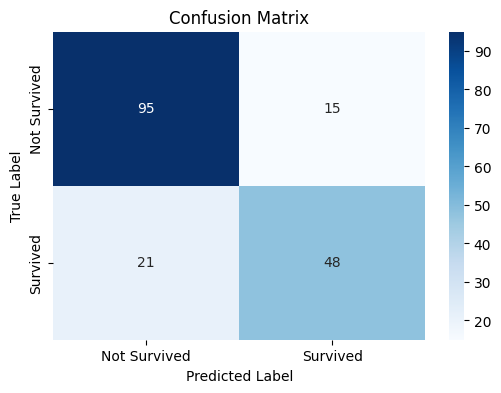

<ipython-input-13-45143055b6de>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=all_features, palette='viridis')


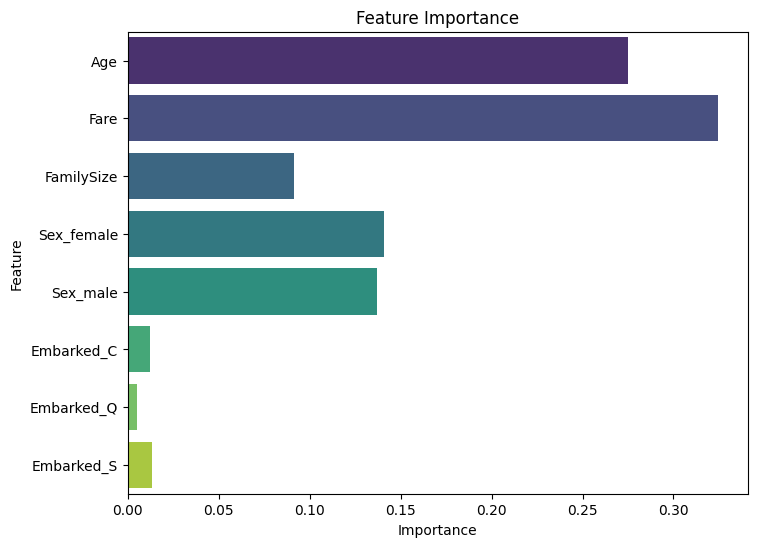

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Best Model Accuracy: 0.8044692737430168
Model with hyperparameter tuning saved.


['titanic_rf_model_advanced.pkl']

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Titanic dataset
data_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic_df = pd.read_csv(data_url)

# Display basic information about the dataset
print("Dataset Info:")
print(titanic_df.info())

print("\nFirst 5 rows:")
print(titanic_df.head())

# Exploratory Data Analysis
print("\nMissing Values:")
print(titanic_df.isnull().sum())

# Feature Engineering: Create new features such as family size
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch']
titanic_df['IsAlone'] = 1
titanic_df['IsAlone'].loc[titanic_df['FamilySize'] > 0] = 0

# Fill missing values using SimpleImputer or KNNImputer
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Sex', 'Embarked']

# Preprocessing pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data into features (X) and target (y)
X = titanic_df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])
y = titanic_df['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance
rf_model = model_pipeline.named_steps['classifier']
feature_importance = rf_model.feature_importances_

# Get feature names after one-hot encoding
encoded_columns = model_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(encoded_columns)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=all_features, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Accuracy with best model
best_accuracy = accuracy_score(y_test, y_pred_best)
print("\nBest Model Accuracy:", best_accuracy)
print("Model with hyperparameter tuning saved.")

# Save the model
import joblib
joblib.dump(best_model, 'titanic_rf_model_advanced.pkl')


